
# Lesson 11 — Introduction to Neural Networks (CS229-style)

This lesson introduces **Neural Networks** from first principles, focusing on:
- Perceptrons as linear classifiers
- Multi-Layer Perceptrons (MLPs)
- Forward propagation (vectorized)
- Geometry and intuition (why depth matters)

Everything is implemented using **NumPy only**.



## Big Picture

A neural network is a **composition of linear functions and nonlinear activations**.

\[
f(x) = W_2 \, g(W_1 x + b_1) + b_2
\]

Key ideas:
- A single neuron = linear model + nonlinearity
- Hidden layers enable **nonlinear decision boundaries**
- Depth allows hierarchical feature reuse


In [134]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)


## 1) From Perceptron to Neural Network


### Single Neuron (Perceptron)

\[
h(x) = g(w^T x + b)
\]

Without the activation function, this is just linear regression / logistic regression.


In [135]:

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def perceptron(X, w, b):
    return sigmoid(X @ w + b)


## 2) XOR: Why One Layer Is Not Enough

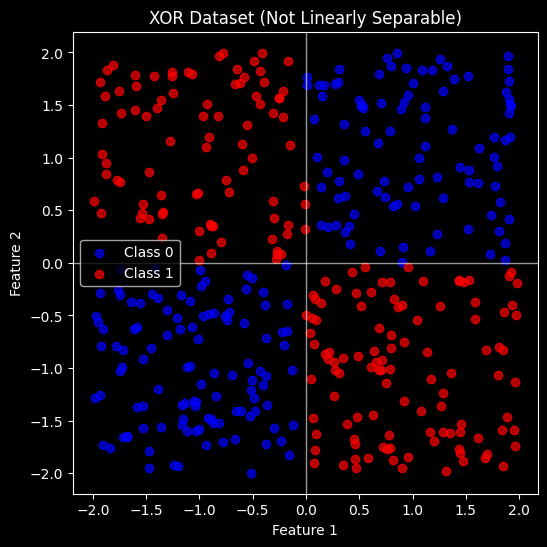

In [136]:

# XOR dataset
n = 400
X = np.random.uniform(-2, 2, size=(n,2))
y = ((X[:,0] > 0) ^ (X[:,1] > 0)).astype(int)

plt.figure(figsize=(6,6))
plt.scatter(X[y==0,0], X[y==0,1], color="blue", alpha=0.7, label="Class 0")
plt.scatter(X[y==1,0], X[y==1,1], color="red",  alpha=0.7, label="Class 1")
plt.axvline(0, color="white", linewidth=1, alpha=0.6)
plt.axhline(0, color="white", linewidth=1, alpha=0.6)
plt.title("XOR Dataset (Not Linearly Separable)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()



A single linear separator **cannot** solve XOR.
We need **hidden units** to break the space into regions.


## 3) One Hidden Layer Neural Network

In [137]:

def forward_mlp(X, params):
    W1, b1, W2, b2 = params
    Z1 = X @ W1 + b1
    A1 = np.tanh(Z1)
    Z2 = A1 @ W2 + b2
    A2 = sigmoid(Z2)
    return A1, A2


In [138]:

# Initialize parameters
h = 6  # hidden units
W1 = np.random.randn(2, h) * 0.5
b1 = np.zeros(h)
W2 = np.random.randn(h, 1) * 0.5
b2 = np.zeros(1)

params = (W1, b1, W2, b2)

# Forward pass
_, preds = forward_mlp(X, params)
print("Initial accuracy:", np.mean((preds.flatten() > 0.5) == y))


Initial accuracy: 0.465


## 4) Visualizing Hidden Layer Features

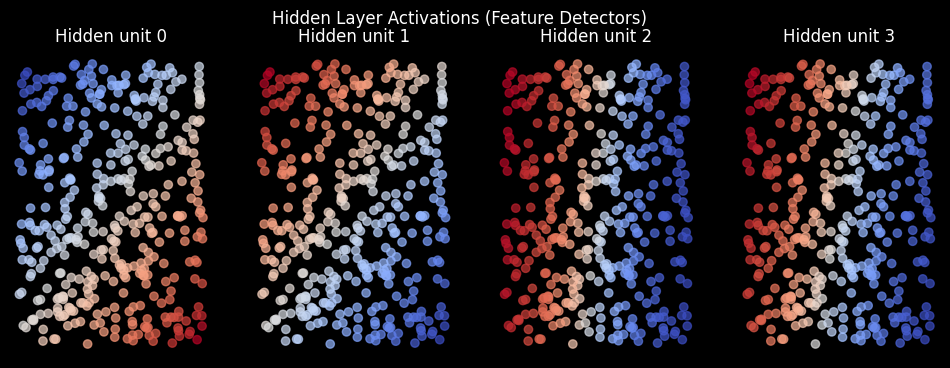

In [139]:

# Visualize hidden unit activations
A1, _ = forward_mlp(X, params)

plt.figure(figsize=(12,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.scatter(X[:,0], X[:,1], c=A1[:,i], cmap="coolwarm", alpha=0.7)
    plt.title(f"Hidden unit {i}")
    plt.axis("off")
plt.suptitle("Hidden Layer Activations (Feature Detectors)")
plt.show()



Each hidden unit acts as a **learned feature detector**.
The output layer combines these features linearly.


## 5) Geometry: From Features to Decision Boundary

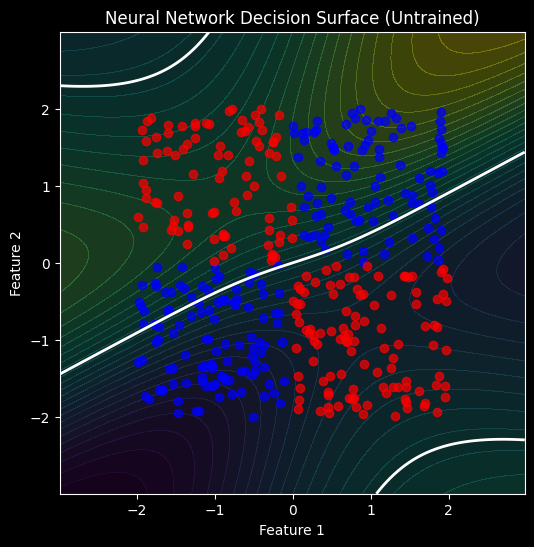

In [140]:

# Decision boundary visualization
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-1, X[:,0].max()+1, 300),
    np.linspace(X[:,1].min()-1, X[:,1].max()+1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
_, P = forward_mlp(grid, params)
P = P.reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, P, levels=30, alpha=0.3)
plt.contour(xx, yy, P, levels=[0.5], colors="white", linewidths=2)
plt.scatter(X[y==0,0], X[y==0,1], color="blue", alpha=0.7)
plt.scatter(X[y==1,0], X[y==1,1], color="red", alpha=0.7)
plt.title("Neural Network Decision Surface (Untrained)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()



Even before training, the network creates **nonlinear partitions**.
Training will *rotate, stretch, and combine* these regions.


In [141]:
def train_nn(X, y, W1, b1, W2, b2, lr=0.05, steps=5000):
    y = y.reshape(-1, 1)

    for _ in range(steps):
        # Forward
        Z1 = X @ W1 + b1
        A1 = np.tanh(Z1)
        Z2 = A1 @ W2 + b2
        A2 = 1 / (1 + np.exp(-Z2))  # sigmoid

        # Gradients (binary cross-entropy)
        dZ2 = A2 - y
        dW2 = A1.T @ dZ2 / len(X)
        db2 = dZ2.mean(axis=0)

        dA1 = dZ2 @ W2.T
        dZ1 = dA1 * (1 - A1**2)
        dW1 = X.T @ dZ1 / len(X)
        db1 = dZ1.mean(axis=0)

        # Update
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

    return W1, b1, W2, b2


In [142]:
W1_tr, b1_tr, W2_tr, b2_tr = train_nn(
    X, y, W1.copy(), b1.copy(), W2.copy(), b2.copy()
)

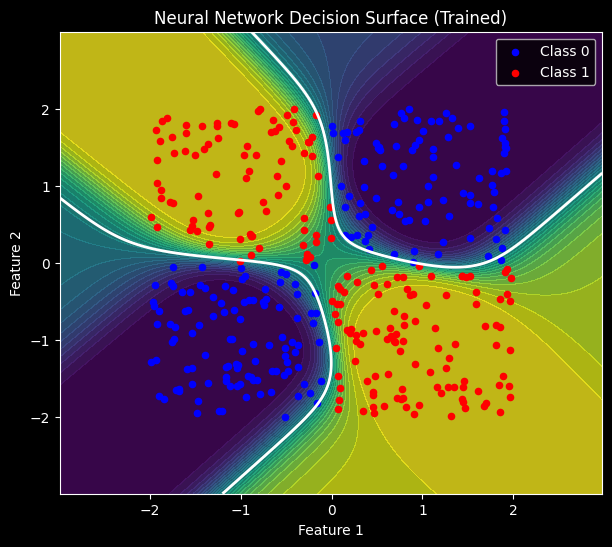

In [143]:
Z1 = grid @ W1_tr + b1_tr
A1 = np.tanh(Z1)
Z2 = A1 @ W2_tr + b2_tr
probs = 1 / (1 + np.exp(-Z2))
Z = probs.reshape(xx.shape)

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, levels=30, cmap="viridis", alpha=0.8)
plt.contour(xx, yy, Z, levels=[0.5], colors="white", linewidths=2)

plt.scatter(X[y==0,0], X[y==0,1], color="blue", s=20, label="Class 0")
plt.scatter(X[y==1,0], X[y==1,1], color="red", s=20, label="Class 1")

plt.title("Neural Network Decision Surface (Trained)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

## 3D Plane Visualization

In [144]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_nn_surface_with_pins(X, y, W1, b1, W2, b2, title):
    # grid for surface
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = nn_prob(grid, W1, b1, W2, b2).reshape(xx.shape)

    # point probabilities (so points can sit on top of surface)
    p = nn_prob(X, W1, b1, W2, b2).reshape(-1)
    eps = 0.02
    z_pts = np.clip(p + eps, 0, 1)

    # optional: subsample points so it looks cleaner
    idx = np.random.choice(len(X), size=min(250, len(X)), replace=False)
    Xs, ys, zs = X[idx], y[idx], z_pts[idx]

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")

    # surface: remove gridlines so it doesn't look like a net
    ax.plot_surface(xx, yy, Z, alpha=0.28, linewidth=0, antialiased=True)

    # points: now placed on top of predicted surface
    ax.scatter(Xs[ys==0,0], Xs[ys==0,1], zs[ys==0],
               color="blue", alpha=0.85, s=22, depthshade=False, label="Class 0")
    ax.scatter(Xs[ys==1,0], Xs[ys==1,1], zs[ys==1],
               color="red", alpha=0.85, s=22, depthshade=False, label="Class 1")
    ax.contour(xx, yy, Z, levels=[0.5], colors="white", linewidths=3, offset=0.5)


    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("p(Class 1 | x)")
    ax.set_zlim(0, 1)
    ax.set_title(title)
    ax.legend(loc="upper right")

    # camera
    ax.view_init(elev=25, azim=-60)
    plt.show()

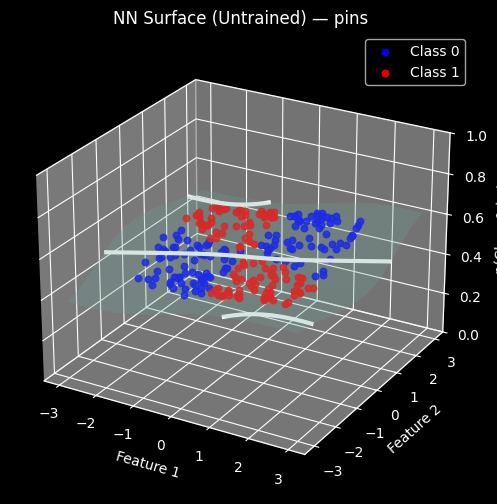

In [145]:
plot_nn_surface_with_pins(X, y, W1, b1, W2, b2, "NN Surface (Untrained) — pins")

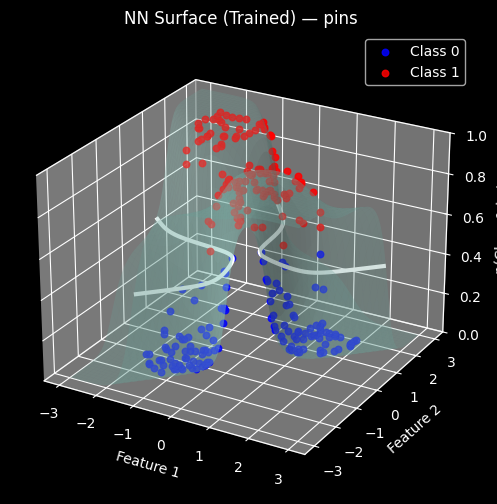

In [146]:
plot_nn_surface_with_pins(X, y, W1_tr, b1_tr, W2_tr, b2_tr, "NN Surface (Trained) — pins")

In [147]:
p_un = nn_prob(X, W1, b1, W2, b2).reshape(-1)
p_tr = nn_prob(X, W1_tr, b1_tr, W2_tr, b2_tr).reshape(-1)

acc_un = np.mean((p_un >= 0.5).astype(int) == y)
acc_tr = np.mean((p_tr >= 0.5).astype(int) == y)

print("Untrained acc:", acc_un)
print("Trained acc:", acc_tr)


Untrained acc: 0.465
Trained acc: 0.9925



## Key Takeaways (Lesson 11)

- A neural network is a **stack of linear maps + nonlinearities**
- Hidden layers enable nonlinear decision boundaries
- XOR is the canonical example that motivates depth
- Hidden units behave like **learned features**
- Forward propagation is fully vectorized and efficient
- Training (backpropagation) will tune these features — that’s Lesson 12
